# Comparing 3 models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv

## Ailsa Craig data

In [2]:
# Reading in the data from the conservation of mass and momentum model
data = pd.read_csv('data/output_2m_270_cofmandm.txt',skiprows=2, delimiter=' ', names=['x', 'y', 'z', 'U_x', 'U_y', 'U_z'])
finaldata = data.set_index(['x', 'y']).sort_values(['x', 'y'])
finaldata

z       U_x       U_y       U_z
x         y                                           
3364237.5 3669412.5  2.0  1.347483 -0.012866 -0.000188
          3669437.5  2.0  1.347654 -0.012516 -0.000552
          3669462.5  2.0  1.347805 -0.012192 -0.000418
          3669487.5  2.0  1.347829 -0.011738 -0.000658
          3669512.5  2.0  1.347871 -0.011210 -0.000492
...                  ...       ...       ...       ...
3370562.5 3675637.5  2.0  0.423031  0.000342 -0.007440
          3675662.5  2.0  0.365179  0.003449 -0.006466
          3675687.5  2.0  0.303102  0.005548 -0.004927
          3675712.5  2.0  0.238207  0.006735 -0.002240
          3675737.5  2.0  0.238207  0.006735 -0.002240

[64516 rows x 4 columns]

In [3]:
## Define a function which calculates the u and v component and wind

def wind_model(n,zr):
    """
    Function to calculate the wind components and overal wind
    Input: 
    - n: n = zr.shape[0]
    - zr: Topography file to be read in
    Output: Wind components and overal wind
    """
    # Iteration to find the inner region thickness l (m)
    l = (z0/8)*(L/z0)**0.9
    for i in range(10):
        l = 2*0.16*L/np.log(l/z0)
    a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))
    
    # Fourier transform
    Fz = fft2(zr)
    Fz = fftshift(Fz)
    
    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0
    
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    return ur,vr,windr

In [4]:
# Define a function to plot the streamplot and the contour lines

def plot_wind(u,v,wind,z,title, n, m, l):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-n,n)*dx
    y = np.arange(-n,n)*dx
    plt.streamplot(x[m:l],y[m:l],u[m:l,m:l],v[m:l,m:l],
                   color=wind[m:l,m:l],
                   linewidth = 2.2, cmap='viridis_r')
    plt.colorbar()
    plt.clim(0, 7)
    cs = plt.contour(x[m:l],y[m:l],z[m:l,m:l],origin='lower', alpha = 0.7, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

In [5]:
# Define function using the Ninja model output

def Ninja_plots(z, u, v, title, col_bar_min, col_bar_max, n, m, l):
    """
    Input:
    - z: elevation file
    - vel: velocity profile from Ninja model
    - ang: angle from Ninja model
    - title: title for subplot
    - col_bar_min and _max: min and max of colorbar (to ensure that colorbar are the same for subplots)
    
    Output: plots a streamplot with the streamlines colored in by wind speed
    """
    u = -vel*np.sin(np.radians(ang))
    v = vel*np.cos(np.radians(ang))
    u = u[:,::-1]
    v = -v[:,::-1]
    wind = np.sqrt(u**2 + v**2)
    
    x = np.arange(-n,n)*dx
    y = np.arange(-n,n)*dx
    plt.streamplot(x[m:l],y[m:l],u[m:l,m:l],v[m:l,m:l],
                   color=wind[m:l,m:l],cmap='viridis_r')
    plt.colorbar()
    plt.clim(col_bar_min, col_bar_max)
    cs = plt.contour(x[m:l],y[m:l],z[m:l,m:l],alpha = 0.7, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

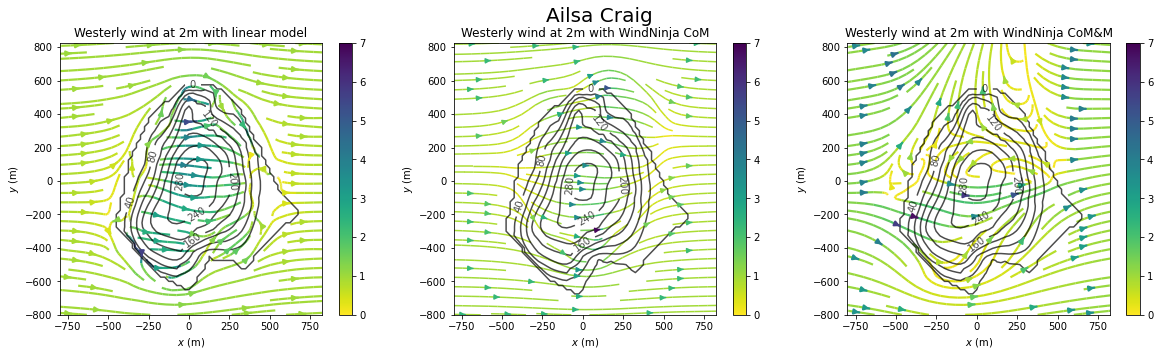

In [6]:
# westerly wind at 2m with different models compared
plt.figure(figsize=(20, 5))

# Westerly wind with the linear model
plt.subplot(131)
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)
z = np.loadtxt('data/AilsaCraig.txt')
n = z.shape[0]
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind at 2m with linear model', 127, 95, 161)

# Westerly wind with the WindNinja Conservation of Mass model
from osgeo import gdal
ds = gdal.Open('data/AilsaCraig.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
plt.subplot(132)
vel = np.loadtxt('data/AilsaCraig_270_25m_2m_vel.asc',skiprows=6)
ang = np.loadtxt('data/AilsaCraig_270_25m_2m_ang.asc',skiprows=6)
Ninja_plots(z, vel, ang, "Westerly wind at 2m with WindNinja CoM", 
            col_bar_min = 0, col_bar_max=7, n=127, m=95, l=161)

# Westerly wind with the WindNinja Conservation of Mass and Momentum model
plt.subplot(133)
u = finaldata['U_x'].to_numpy().reshape(254, 254)
v = finaldata['U_y'].to_numpy().reshape(254, 254)
w = finaldata['U_z'].to_numpy().reshape(254, 254)
wind = np.sqrt(u**2 + v**2)
plot_wind(u, v, wind, z, 'Westerly wind at 2m with WindNinja CoM&M', 127, 95, 161)
plt.suptitle('Ailsa Craig', size=20)
plt.show()

## North Berwick Law

*Questions: Why is the CoM model for NB have 2.7m/s everywhere?*

In [11]:
# Reading in the data from the conservation of mass and momentum model
data = pd.read_csv('data/output_2m_270_cofmandm_BL.txt',skiprows=2, delimiter=' ', names=['x', 'y', 'z', 'U_x', 'U_y', 'U_z'])
finaldata = data.set_index(['x', 'y']).sort_values(['x', 'y'])
finaldata

z       U_x       U_y       U_z
x         y                                             
3503662.5 3730387.5  13.36  1.349950 -0.005291 -0.000543
          3730412.5  13.16  1.347641 -0.005250 -0.000928
          3730437.5  13.12  1.345202 -0.005347 -0.001013
          3730462.5  13.08  1.345078 -0.005619 -0.001088
          3730487.5  13.04  1.347114 -0.005708 -0.000929
...                    ...       ...       ...       ...
3509987.5 3736612.5   2.00  0.925071  0.101292 -0.004248
          3736637.5   2.00  0.906498  0.109720 -0.004418
          3736662.5   2.00  0.889431  0.116853 -0.004877
          3736687.5   2.00  0.874597  0.127733 -0.005463
          3736712.5   2.00  0.874597  0.127733 -0.005463

[64516 rows x 4 columns]

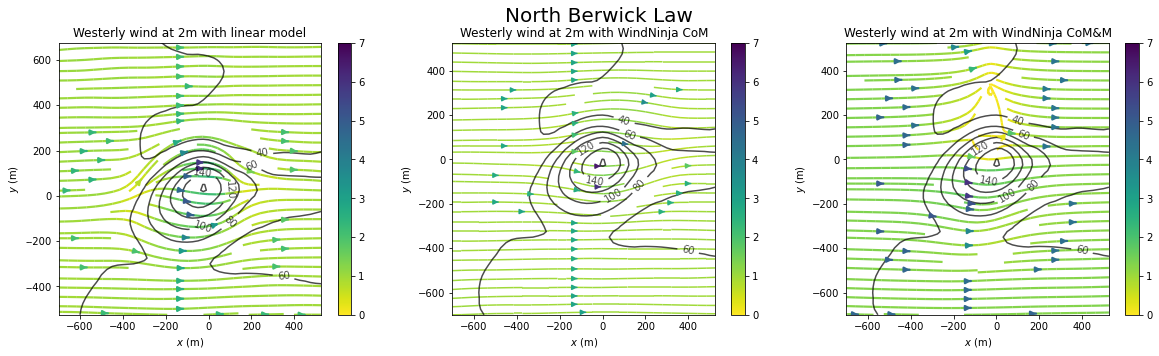

In [8]:
# westerly wind at 2m with different models compared
plt.figure(figsize=(20, 5))

# Westerly wind with the linear model
plt.subplot(131)
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)
z = np.loadtxt('data/NorthBerwickLawBlend1.txt')
n = z.shape[0]
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind at 2m with linear model', 128, 100, 150)
plt.ylim(525,-675)
plt.yticks([400, 200, 0, -200, -400, -600],['--400', '--200', '0', '200', '400', '600'] )

# Westerly wind with the WindNinja Conservation of Mass model
from osgeo import gdal
ds = gdal.Open('data/NorthBerwickLaw.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
plt.subplot(132)
vel = np.loadtxt('data/NorthBerwickLaw_270_1_25m_vel.asc',skiprows=6)
ang = np.loadtxt('data/NorthBerwickLaw_270_1_25m_ang.asc',skiprows=6)
Ninja_plots(z, vel, ang, "Westerly wind at 2m with WindNinja CoM", 
            col_bar_min = 0, col_bar_max=7, n=128, m=100, l=150)

# Westerly wind with the WindNinja Conservation of Mass and Momentum model
plt.subplot(133)
u = finaldata['U_x'].to_numpy().reshape(254, 254)
v = finaldata['U_y'].to_numpy().reshape(254, 254)
w = finaldata['U_z'].to_numpy().reshape(254, 254)
wind = np.sqrt(u**2 + v**2)
plot_wind(u, v, wind, z, 'Westerly wind at 2m with WindNinja CoM&M', n=128, m=100, l=150)
plt.suptitle('North Berwick Law', size=20)
plt.show()


## Inchkeith 

*Questions: Why is the CoM model for I have 2.7m/s everywhere?*

In [13]:
# Reading in the data from the conservation of mass and momentum model
data = pd.read_csv('data/output_2m_270_cofmandm_I.txt',skiprows=2, delimiter=' ', names=['x', 'y', 'z', 'U_x', 'U_y', 'U_z'])
finaldata = data.set_index(['x', 'y']).sort_values(['x', 'y'])
finaldata

z       U_x       U_y       U_z
x         y                                           
3503662.5 3730387.5  2.0  1.347484 -0.023635 -0.000454
          3730412.5  2.0  1.347544 -0.022229 -0.001112
          3730437.5  2.0  1.347746 -0.020264 -0.000860
          3730462.5  2.0  1.347873 -0.018466 -0.001288
          3730487.5  2.0  1.347953 -0.016575 -0.001035
...                  ...       ...       ...       ...
3509987.5 3736612.5  2.0  0.883512  0.050058 -0.004077
          3736637.5  2.0  0.860690  0.056839 -0.004044
          3736662.5  2.0  0.841706  0.062985 -0.006203
          3736687.5  2.0  0.825940  0.075751 -0.007947
          3736712.5  2.0  0.825940  0.075751 -0.007947

[64516 rows x 4 columns]

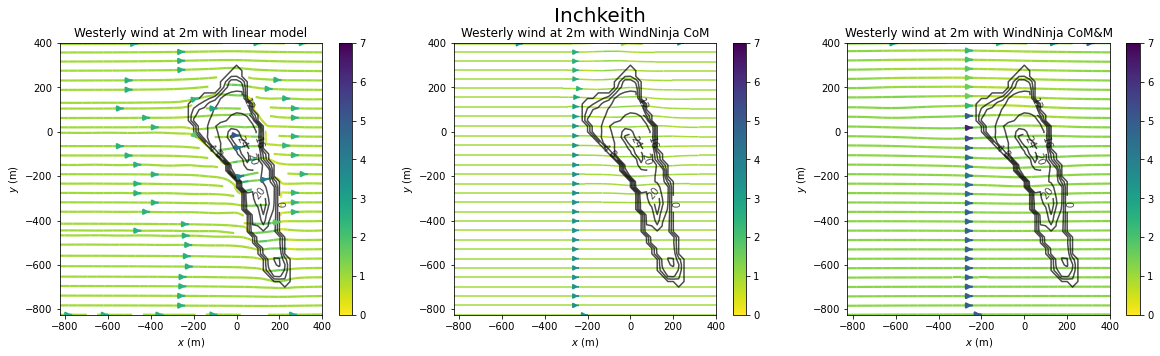

In [14]:
# westerly wind at 2m with different models compared
plt.figure(figsize=(20, 5))

# Westerly wind with the linear model
plt.subplot(131)
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)
z = np.loadtxt('data/Inchkeith.txt')
n = z.shape[0]
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind at 2m with linear model', 128, 95, 145)

# Westerly wind with the WindNinja Conservation of Mass model
from osgeo import gdal
ds = gdal.Open('data/Inchkeith.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
plt.subplot(132)
vel = np.loadtxt('data/Inchkeith_270_1_25m_vel.asc',skiprows=6)
ang = np.loadtxt('data/Inchkeith_270_1_25m_ang.asc',skiprows=6)
Ninja_plots(z, vel, ang, "Westerly wind at 2m with WindNinja CoM", 
            col_bar_min = 0, col_bar_max=7, n=128, m=95, l=145)

# Westerly wind with the WindNinja Conservation of Mass and Momentum model
plt.subplot(133)
u = finaldata['U_x'].to_numpy().reshape(254, 254)
v = finaldata['U_y'].to_numpy().reshape(254, 254)
w = finaldata['U_z'].to_numpy().reshape(254, 254)
wind = np.sqrt(u**2 + v**2)
plot_wind(u, v, wind, z, 'Westerly wind at 2m with WindNinja CoM&M', n=128, m=95, l=145)
plt.suptitle('Inchkeith', size=20)
plt.show()